<a href="https://colab.research.google.com/github/nimishgarg24/Text-Summarizer/blob/main/Text_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Knowledge Graph based Hybrid Extractive-Abstractive Text Summarization**

**Installing Libraries**

In [ ]:
!pip install PyPDF2 --q
!pip install transformers --q
!apt-get install -y poppler-utils --q
!pip install transformers networkx --q
!transformers-cli cache clear --q




# !pip install --upgrade pip
# !pip install spacy-transformers --q
# !python -m spacy download en_core_web_lg --q
# !python -m spacy download en_trf_bertbaseuncased_lg --q
# !pip install SentencePiece --q
# !pip install textract --q
# !pip install spacy --q
# !pip install sacremoses --q
# !pip install textacy --q
# !pip install spacy==3.0.0 --q
# !python -m spacy download en_trf_bertbaseuncased_lg --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.2 MB/s eta 0:00:00
E: Command line option --q is not understood in combination with the other options
2023-11-29 04:54:28.333221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 04:54:28.333279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 04:54:28.333325: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 04:54:30.660978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: transformers-cli <command> [<args>]
Transformers CLI tool: error: 

**Importing  libraries**

In [ ]:
import PyPDF2
from io import StringIO
import os
import requests
from bs4 import BeautifulSoup
import torch
from transformers import LongformerTokenizer, LongformerModel, pipeline
import nltk
import re
import networkx as nx
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
import numpy as np




nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# The following output must be cuda to ensure that the GPU is used

cuda:0


**Sentence segmentation function**

In [ ]:
def split_into_sentences(paragraph):
    sentences = nltk.sent_tokenize(paragraph)
    return sentences

**Set up the Abstractive summarization model**

In [ ]:
summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum", device='cuda:0')



config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

**Set up the Extractive summarization model**

In [ ]:

longformer_tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
longformer_model = LongformerModel.from_pretrained('allenai/longformer-base-4096')


longformer_model.to(device)
print("Loader longformer to device")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Loader longformer to device


**Function to count words in a sentence**

In [ ]:
def count_words(sentence):
    return len(re.findall(r"\w+", sentence))

In [ ]:
!pip install pdfminer.six --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.0 MB/s eta 0:00:00


**Input reading functions**

In [ ]:
# Function to read and extract text from a PDF document
def read_pdf(file_path):
    if not os.path.isfile(file_path) or not file_path.endswith('.pdf'):
        raise ValueError('Invalid file path or file format. Please provide a valid PDF file.')
    from pdfminer.high_level import extract_text
    text = extract_text(file_path)
    return text


# Function to read and extract text from a text document
def read_text(file_path):
    if not os.path.isfile(file_path) or not file_path.endswith('.txt'):
        raise ValueError('Invalid file path or file format. Please provide a valid text file.')
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        return text

# Function to read and extract text from a website URL
def read_url(url):
    try:
        response = requests.get(url)
        html_content = response.text
        soup = BeautifulSoup(html_content, 'html.parser')
        main_content = soup.find(class_='main-content')
        text = main_content.get_text()
        return text
    except:
        raise ValueError('Invalid URL or unable to extract text from URL. Please provide a valid website URL.')

**Knowledge-Graph based Extractive summarization functions**

In [ ]:
def sentence_embedding(sentence):
    # Tokenize the sentence
    tokens = longformer_tokenizer.tokenize(sentence)

    # Convert tokens to input IDs
    input_ids = longformer_tokenizer.encode(tokens, add_special_tokens=True)

    # Convert input IDs to a tensor
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)

    # Get the last hidden states from the Longformer model
    with torch.no_grad():
        outputs = longformer_model(input_ids=input_ids)
        last_hidden_states = outputs.last_hidden_state

    # Average pooling to get the sentence embedding
    sentence_embedding = torch.mean(last_hidden_states, dim=1).squeeze(0).cpu().numpy()

    return sentence_embedding

import matplotlib.pyplot as plt

def create_knowledge_graph(text):
    # Split the text into sentences
    sentences = sent_tokenize(text)
    # Create an empty graph
    graph = nx.Graph()
    # Add sentences as nodes to the graph
    graph.add_nodes_from(range(len(sentences)))

    embeddings = []
    for sentence in sentences:
        embeddings.append(sentence_embedding(sentence))
    embeddings = np.vstack(embeddings)

    similarity_matrix = cosine_similarity(embeddings, embeddings)

    # Calculate sentence similarity and add edges to the graph
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            similarity = similarity_matrix[i, j]
            graph.add_edge(i, j, weight=similarity)

    # Visualize the knowledge graph
    pos = nx.spring_layout(graph)  # Layout for node positioning
    weights = nx.get_edge_attributes(graph, 'weight')  # Edge weights

    plt.figure(figsize=(10, 8))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=10, width=1.5, alpha=0.8)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=weights)
    plt.title("Knowledge Graph Visualization")
    plt.show()

    return graph


def extractive_summarization_with_knowledge_graph(input_text):
    sentences = sent_tokenize(input_text)
    # Create the knowledge graph
    graph = create_knowledge_graph(input_text)
    # Apply TextRank algorithm to rank the sentences based on graph centrality
    sentence_scores = nx.pagerank(graph, weight='weight')
    # Sort the sentences by score in descending order
    ranked_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)
    # Select the top sentences as the summary
    summary_sentences = ranked_sentences[:10]  # Adjust the number of sentences for the summary
    # Sort the summary sentences based on their original order
    summary_sentences.sort()
    # Construct the final summary
    summary = ' '.join([sentences[idx] for idx in summary_sentences])
    return summary

**Abstractive summarization function**

In [ ]:
def abstractive_summarization(input_text):
    num_of_sentence_per_chunk = 10
    sentences = split_into_sentences(input_text)
    sentence_chunks = []
    summarised_output = ''
    ct = 0
    while ct <= len(sentences):
        chunk = sentences[ct: ct+num_of_sentence_per_chunk]
        chunk = ' '.join(chunk)
        if len(chunk) > 700:
            sentence_chunks.append(chunk)
        ct += num_of_sentence_per_chunk
    progress = 0
    for chunk in sentence_chunks:
        data = summarizer(chunk, min_length=150, max_length=200)[0]['summary_text']
        summarised_output += data
        progress += 1
    return summarised_output



**H-E-A-T summarization function**

In [ ]:
def summarize_file(file_path_or_url):
    # Check if the input is a file path or a website URL
    if os.path.isfile(file_path_or_url):
        file_path = file_path_or_url
        # Read and extract text from the input file
        if file_path.endswith('.pdf'):
            text = read_pdf(file_path)
        elif file_path.endswith('.txt'):
            text = read_text(file_path)
        else:
            raise ValueError('Invalid file format. Please provide a valid PDF or text file.')
    else:
        # Read and extract text from the website URL
        text = read_url(file_path_or_url)

    print('TEXT: -------------------\n',text,'\n-----------------------------')

    # Perform extractive summarization
    extractive_summary = extractive_summarization_with_knowledge_graph(text)

    # Perform abstractive summarization
    abstractive_summary = abstractive_summarization(text)

    return abstractive_summary, extractive_summary

**Main body**

Saving doc8.pdf to doc8.pdf
TEXT: -------------------
 The Asgardian Loki encounters the Other, the leader of an extraterrestrial race known as 
the Chitauri. In exchange for retrieving the Tesseract,[c] a powerful energy source of unknown 
potential, the Other promises Loki an army with which he can subjugate Earth. Nick Fury, director 
of the espionage agency S.H.I.E.L.D., arrives at a remote research facility, where physicist 
Dr. Erik Selvig is leading a team experimenting on the Tesseract. The Tesseract suddenly 
activates and opens a wormhole, allowing Loki to reach Earth. Loki steals the Tesseract and 
uses his scepter to enslave Selvig and other agents, including Clint Barton, to aid him. 

In response, Fury reactivates the "Avengers Initiative". Agent Natasha Romanoff heads 
to Kolkata to recruit Dr. Bruce Banner to trace the Tesseract through its gamma 
radiation emissions. Fury approaches Steve Rogers to retrieve the Tesseract, and Agent Phil 
Coulson visits Tony Stark to ha

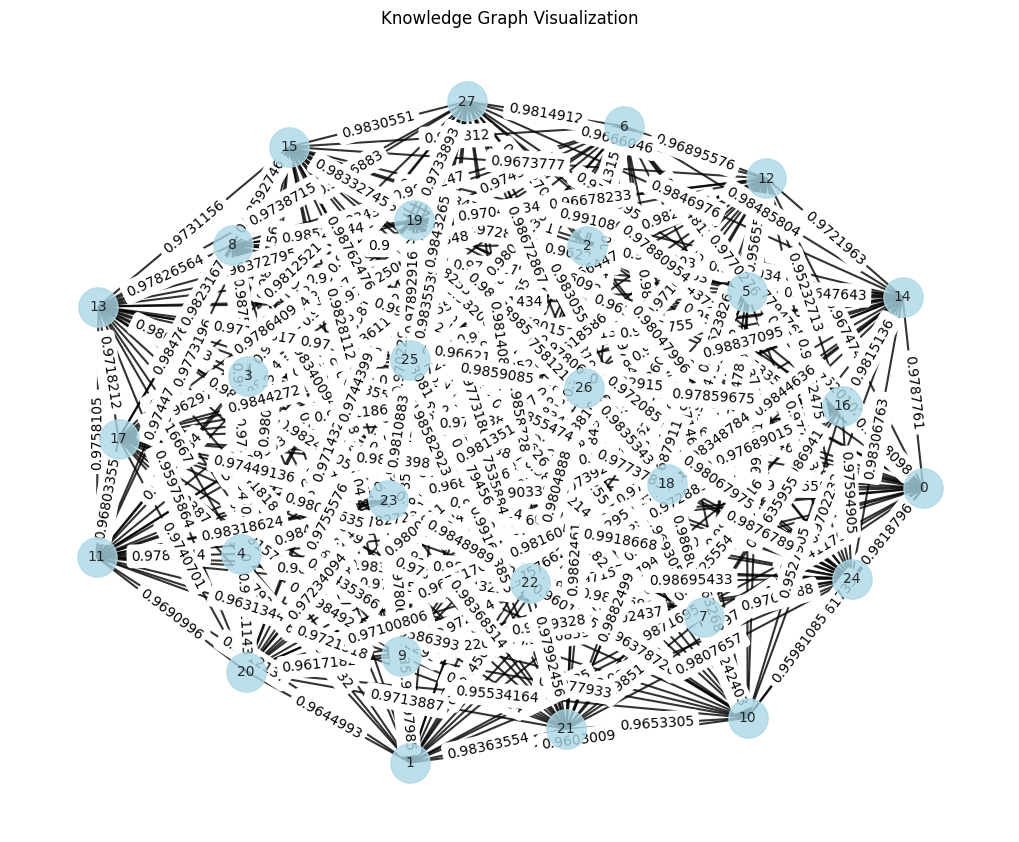

Your max_length is set to 200, but your input_length is only 199. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=99)


Extractive Summary:
The Tesseract suddenly 
activates and opens a wormhole, allowing Loki to reach Earth. Loki steals the Tesseract and 
uses his scepter to enslave Selvig and other agents, including Clint Barton, to aid him. Agent Natasha Romanoff heads 
to Kolkata to recruit Dr. Bruce Banner to trace the Tesseract through its gamma 
radiation emissions. Fury approaches Steve Rogers to retrieve the Tesseract, and Agent Phil 
Coulson visits Tony Stark to have him check Selvig's research. Loki is in Stuttgart, where Barton 
steals the iridium needed to stabilize the Tesseract's power, leading to a confrontation with 
Rogers, Stark, and Romanoff that ends with Loki's surrender. As they argue, Loki's agents attack the Helicarrier, and the stress causes 
Banner to transform into the Hulk. Stark and Rogers work to restart the damaged engine, and 
Thor attempts to stop the Hulk's rampage. Loki uses the Tesseract and a wormhole generator Selvig built 
to open a wormhole above Stark Tower to t

In [ ]:
# file_path = 'https://www.nature.com/articles/d41586-023-01714-6'
#file_path ='/content/EARTH EATS (1).pdf'
from google.colab import files

# Upload the PDF file
uploaded = files.upload()


# Assuming you only have one file



 #Assuming you only have one file



# Get the file path
file_path = next(iter(uploaded))
abstractive_summary, extractive_summary = summarize_file(file_path)
print("Extractive Summary:")
print(extractive_summary)
print("\nAbstractive Summary:")
print(abstractive_summary)
print("\nThe hybrid method Summary is:")
hybrid_summary = abstractive_summarization(extractive_summary)
print(hybrid_summary)

**size comparison**

In [ ]:
try:
    # Try opening the file as a text file
    with open(file_path, 'r', encoding='utf-8') as file:
        in_text = file.read()
except (FileNotFoundError,UnicodeDecodeError):
    # If a UnicodeDecodeError occurs, it means the file is not a text file
    # In that case, read the PDF file separately
    if file_path.endswith('.pdf'):
        in_text = read_pdf(file_path)
    else:
        # If it's not a PDF file, assume it's a URL and attempt to read from it
        try:
            in_text = read_url(file_path)
        except ValueError:
            raise ValueError('Invalid URL or unable to extract text from URL. Please provide a valid website URL.')

print(f"Words in Input text: {count_words(in_text)}")
print(f"Words in Extractive summary: {count_words(extractive_summary)}")
print(f"Words in Abstractive summary: {count_words(abstractive_summary)}")
print(f"Words in Hybrid summary: {count_words(hybrid_summary)}")

Words in Input text: 531
Words in Extractive summary: 212
Words in Abstractive summary: 309
Words in Hybrid summary: 103


# **Evaluating the summarization performance**

In [ ]:
!pip install rouge


**Rouge score comparison for the summaries**

In [ ]:
from rouge import Rouge

def evaluate_summary(summary, reference):
    rouge = Rouge()
    scores = rouge.get_scores(summary, reference)
    return scores

# Evaluate the performance of the summarization system using a reference summary

# Assuming reference_summary is the ground truth or a high-quality summary
# reference_summary = "The input text comprehensively explores a wide range of aspects related to the topic, delving into intricate details, providing insightful analysis, and presenting multiple perspectives. The summary showcases a meticulous selection of key points, crucial information, and critical findings, ensuring a comprehensive and thorough overview of the main ideas conveyed in the text. It effectively captures the essence of the topic, offering a nuanced understanding and facilitating a deeper exploration of the subject matter." # This is the reference summary

reference_summary = "EARTH EATS is an app-based solution aimed at reducing food wastage and malnourishment. It connects producers and consumers, allowing the sale of excess food at discounted prices. By minimizing waste, providing affordable food, and creating employment opportunities, EARTH EATS addresses the global problem of food wastage. With a comprehensive approach and unique features, such as offering cooked food and local food information, EARTH EATS sets itself apart from competitors. The platform's potential for profitability and growth is significant."

#reference_summary = "EARTH EATS tackles the global problem of food wastage and malnourishment through an app that connects producers and consumers. By selling excess food at discounted prices, reducing reliance on refrigeration, and creating employment opportunities, EARTH EATS aims to minimize waste, provide affordable food, and promote a greener Earth. With a comprehensive approach that addresses multiple aspects, EARTH EATS stands out among competitors and has the potential for significant growth and profitability."


# Evaluate the quality of the generated summary using evaluation metrics
# We can use evaluation metrics such as ROUGE or BLEU to compare the generated summary with the reference summary.
# Here ROUGE metric is used
# Perform the necessary evaluation and print the evaluation results

print("Summary Evaluation Results:")
print("Abstractive Summary:")
print(evaluate_summary(abstractive_summary, reference_summary))
print("Extractive Summary:")
print(evaluate_summary(extractive_summary, reference_summary))
print("Hybrid Summary:")
print(evaluate_summary(hybrid_summary, reference_summary))


Summary Evaluation Results:
Abstractive Summary:
[{'rouge-1': {'r': 0.18333333333333332, 'p': 0.06179775280898876, 'f': 0.09243697101899599}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.18333333333333332, 'p': 0.06179775280898876, 'f': 0.09243697101899599}}]
Extractive Summary:
[{'rouge-1': {'r': 0.11666666666666667, 'p': 0.0546875, 'f': 0.07446808076052538}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.11666666666666667, 'p': 0.0546875, 'f': 0.07446808076052538}}]
Hybrid Summary:
[{'rouge-1': {'r': 0.05, 'p': 0.05172413793103448, 'f': 0.0508474526285555}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.05, 'p': 0.05172413793103448, 'f': 0.0508474526285555}}]


**F1 score comparison of summaries**

In [ ]:
from rouge import Rouge

def evaluate_summary(summary, reference):
    rouge = Rouge()
    scores = rouge.get_scores(summary, reference)
    return scores  # Return the first score in the list


def calculate_average_f_scores(scores):
    average_score = 0
    total = 0
    for metric in scores[0]:
        total += scores[0][metric]['f']
        #total = sum(score[metric] for score in scores)
    average_score = total / 3
    return average_score

# Example usage

# reference_summary = "The input text comprehensively explores a wide range of aspects related to the topic, delving into intricate details, providing insightful analysis, and presenting multiple perspectives. The summary showcases a meticulous selection of key points, crucial information, and critical findings, ensuring a comprehensive and thorough overview of the main ideas conveyed in the text. It effectively captures the essence of the topic, offering a nuanced understanding and facilitating a deeper exploration of the subject matter."

reference_summary = "EARTH EATS is an app-based solution aimed at reducing food wastage and malnourishment. It connects producers and consumers, allowing the sale of excess food at discounted prices. By minimizing waste, providing affordable food, and creating employment opportunities, EARTH EATS addresses the global problem of food wastage. With a comprehensive approach and unique features, such as offering cooked food and local food information, EARTH EATS sets itself apart from competitors. The platform's potential for profitability and growth is significant."

#reference_summary = "EARTH EATS tackles the global problem of food wastage and malnourishment through an app that connects producers and consumers. By selling excess food at discounted prices, reducing reliance on refrigeration, and creating employment opportunities, EARTH EATS aims to minimize waste, provide affordable food, and promote a greener Earth. With a comprehensive approach that addresses multiple aspects, EARTH EATS stands out among competitors and has the potential for significant growth and profitability."


# Evaluate summaries
#reference_scores = evaluate_summary(reference_summary, reference_summary)
abstractive_scores = evaluate_summary(abstractive_summary, reference_summary)
extractive_scores = evaluate_summary(extractive_summary, reference_summary)
hybrid_scores = evaluate_summary(hybrid_summary, reference_summary)


# Calculate average scores
#average_reference_score = calculate_average_f_scores(reference_scores)
average_abstractive_score = calculate_average_f_scores(abstractive_scores)
average_extractive_score = calculate_average_f_scores(extractive_scores)
average_hybrid_score = calculate_average_f_scores(hybrid_scores)

# Print average scores for comparison
print("********** Summarization Performance **********\n")
# print("Reference Summary:")
# print(average_reference_score)
print("\nAbstractive Summary:")
print(average_abstractive_score)
print("\nExtractive Summary:")
print(average_extractive_score)
print("\nHybrid Summary:")
print(average_hybrid_score)

# Compare average scores and determine the better summary
best_summary = max(average_abstractive_score, average_extractive_score, average_hybrid_score)
if best_summary == average_abstractive_score:
    print("\nThe abstractive summary is better.")
elif best_summary == average_extractive_score:
    print("\nThe extractive summary is better.")
else:
    print("\nThe hybrid summary is better.")
print('\n')

********** Summarization Performance **********


Abstractive Summary:
0.061624647345997326

Extractive Summary:
0.04964538717368359

Hybrid Summary:
0.03389830175237033

The abstractive summary is better.




In [ ]:
def evaluate_summary(summary, reference):
    rouge = Rouge()
    scores = rouge.get_scores(summary, reference)
    f1_scores = [score['rouge-l']['f'] for score in scores]
    return f1_scores[0]



# Example usage
# reference_summary = "EARTH EATS tackles the global problem of food wastage and malnourishment through an app that connects producers and consumers. By selling excess food at discounted prices, reducing reliance on refrigeration, and creating employment opportunities, EARTH EATS aims to minimize waste, provide affordable food, and promote a greener Earth. With a comprehensive approach that addresses multiple aspects, EARTH EATS stands out among competitors and has the potential for significant growth and profitability."
reference_summary = "EARTH EATS is an app-based solution aimed at reducing food wastage and malnourishment. It connects producers and consumers, allowing the sale of excess food at discounted prices. By minimizing waste, providing affordable food, and creating employment opportunities, EARTH EATS addresses the global problem of food wastage. With a comprehensive approach and unique features, such as offering cooked food and local food information, EARTH EATS sets itself apart from competitors. The platform's potential for profitability and growth is significant."



# Evaluate summaries
abstractive_score = evaluate_summary(abstractive_summary, reference_summary)
extractive_score = evaluate_summary(extractive_summary, reference_summary)
hybrid_score = evaluate_summary(hybrid_summary, reference_summary)


# Display average scores
print("********** Summarization Performance **********\n")
print("\nAbstractive Summary Average Score:")
print(abstractive_score)
print("\nExtractive Summary Average Score:")
print(extractive_score)
print("\nHybrid Summary Average Score:")
print(hybrid_score)


********** Summarization Performance **********


Abstractive Summary Average Score:
0.09243697101899599

Extractive Summary Average Score:
0.07446808076052538

Hybrid Summary Average Score:
0.0508474526285555
